<h1><center>Deep Learning</center></h1>
<h2><center>Assignment # 7</center></h2>
<h3><center>Urdu MNIST Classification</center></h3>

<h1>Mounting drive to access data</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


<h1>Creating Zipped data folder in colab</h1>

In [2]:
'''
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1DMvh77launTo2CuMV93I6GJa1eAhqfTO'
downloaded = drive.CreateFile({'id': file_id})
print(downloaded.GetContentFile('dataset.zip'))
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
#print('Downloaded content "{}"'.format(downloaded.GetContentFile('DOWNLOAD.tar')))
'''


     |████████████████████████████████| 993kB 1.8MB/s 
None


<h1>Unzipping data in colab notebook to decrease computation time</h1>

In [0]:
import zipfile
data = zipfile.ZipFile('dataset.zip', 'r')
data.extractall('data/')
data.close()

In [0]:
path = '/content/data/cropped_months'

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Defining transforms to apply on the data</h1>

In [0]:
train_transform = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor()])
test_transform = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor(),])

training_images = datasets.ImageFolder(path + '/train', transform=train_transform)
testing_images = datasets.ImageFolder(path + '/test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(training_images, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_images, batch_size=8, shuffle=True)

classes = training_images.classes

<h1><center>EXPERIMENTS on PRE-TRAINED NETWORKS</center></h1>

<h1>VGG-16 Experiment 1(no finetuning, no change in last layer)</h1>

In [0]:
VGG_16 = models.vgg16(pretrained=True)
for param in VGG_16.features.parameters():
    param.require_grad = False
for param in VGG_16.classifier.parameters():
    param.require_grad = False

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(VGG_16.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_16.to(gpu)
VGG_16.train()

for epoch in range(1):
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = VGG_16(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()

In [0]:
total_samples = 0
correct_predictions = 0
actual_Y=[]
predicted_Y=[]
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = VGG_16(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

99.30555555555556


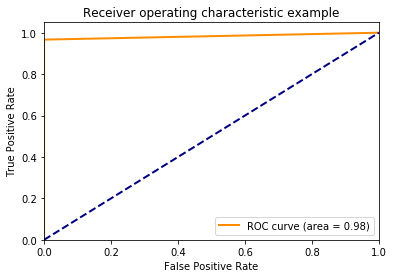

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h1>VGG-16 Experiment 2(no finetuning, updated last layer according to number of classes in my data)</h1>

In [0]:
VGG_16 = models.vgg16(pretrained=True)
last_layer_input = VGG_16.classifier[6].in_features
classifier = list(VGG_16.classifier.children())[:-1]
classifier.extend([nn.Linear(last_layer_input, len(classes))])
VGG_16.classifier = nn.Sequential(*classifier)
for param in VGG_16.features.parameters():
    param.require_grad = False
for param in VGG_16.classifier.parameters():
    param.require_grad = False

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(VGG_16.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_16.to(gpu)
VGG_16.train()

for epoch in range(1):
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = VGG_16(x)
        #print(predictions.shape)
        loss = Cross_Entropy_Loss(predictions,y)
        #print(loss)
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()

In [0]:
total_samples = 0
correct_predictions = 0
actual_Y=[]
predicted_Y=[]
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = VGG_16(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

98.95833333333334


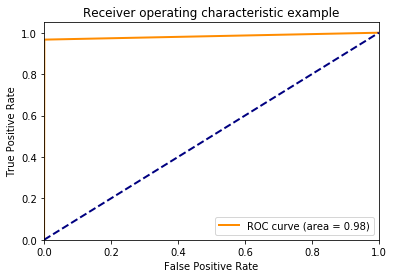

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h1>VGG-16 Experiment 3(finetuning & updated last layer according to number of classes in my data)</h1>

In [0]:
VGG_16 = models.vgg16(pretrained=True)
last_layer_input = VGG_16.classifier[6].in_features
classifier = list(VGG_16.classifier.children())[:-1]
classifier.extend([nn.Linear(last_layer_input, len(classes))])
VGG_16.classifier = nn.Sequential(*classifier)
for param in VGG_16.features.parameters():
    param.require_grad = False

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(VGG_16.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_16.to(gpu)
VGG_16.train()
Losses = []
Accuracies =[]
Epochs =[]


for epoch in range(10):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = VGG_16(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = VGG_16(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)

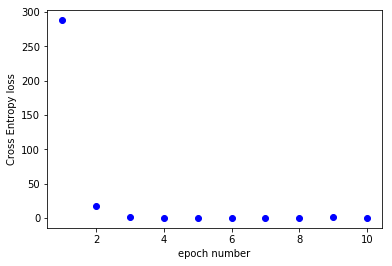

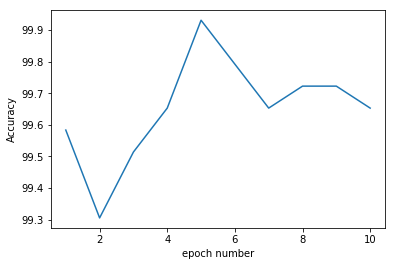

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = VGG_16(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

99.65277777777779


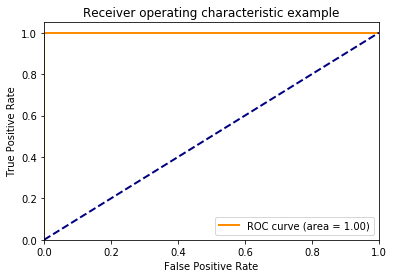

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[120   0   0   0   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0   0   0]
 [  0   0   0   0   0 120   0   0   0   0   0   0]
 [  0   0   0   0   2   0 118   0   0   0   0   0]
 [  0   1   0   0   0   0   0 119   0   0   0   0]
 [  0   0   0   0   0   0   0   0 120   0   0   0]
 [  0   0   0   0   0   0   0   0   0 118   0   2]
 [  0   0   0   0   0   0   0   0   0   0 120   0]
 [  0   0   0   0   0   0   0   0   0   0   0 120]]


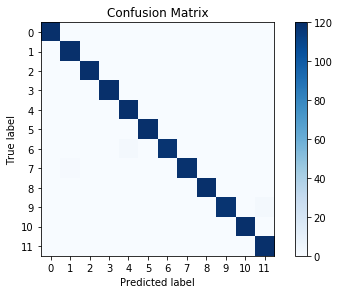

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>RESNET-50 Experiment 1(no finetuning, no change in last layer)</h1>

In [0]:
RESNET_50 = models.resnet50(pretrained=True)
#print(resnet50)
for param in RESNET_50.parameters():
    param.require_grad = False

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(RESNET_50.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESNET_50.to(gpu)
RESNET_50.train()

for epoch in range(1):
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = RESNET_50(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = RESNET_50(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

98.05555555555556


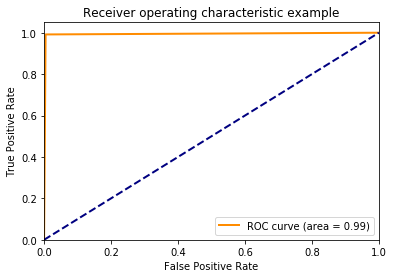

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h1>RESNET-50 Experiment 2(no finetuning, updated last layer according to number of classes in my data)</h1>

In [0]:
RESNET_50 = models.resnet50(pretrained=True)
#print(resnet50)
last_layer_input = RESNET_50.fc.in_features
RESNET_50.fc = nn.Linear(last_layer_input, len(classes))
for param in RESNET_50.parameters():
    param.require_grad = False

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(RESNET_50.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESNET_50.to(gpu)
RESNET_50.train()

for epoch in range(1):
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = RESNET_50(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = RESNET_50(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

98.88888888888889


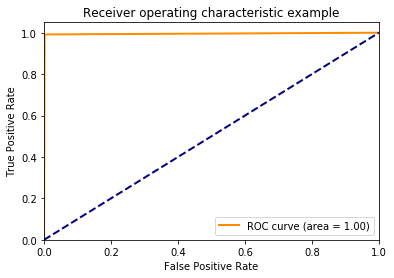

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h1>RESNET-50 Experiment 3(finetuning & updated last layer according to number of classes in my data)</h1>

In [0]:
RESNET_50 = models.resnet50(pretrained=True)
#print(resnet50)
last_layer_input = RESNET_50.fc.in_features
RESNET_50.fc = nn.Linear(last_layer_input, len(classes))

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(RESNET_50.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESNET_50.to(gpu)
RESNET_50.train()
Losses = []
Accuracies =[]
Epochs =[]


for epoch in range(10):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = RESNET_50(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = RESNET_50(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)

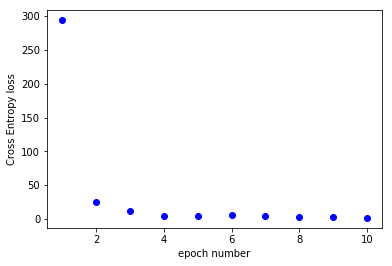

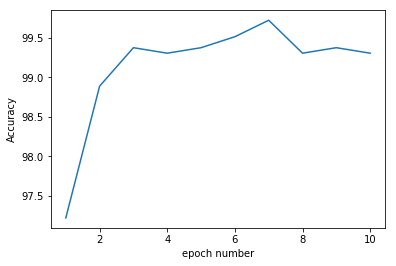

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = RESNET_50(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

99.16666666666667


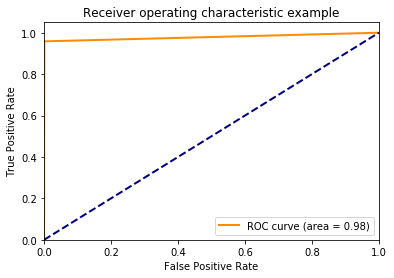

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[120   0   0   0   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0   0   0   0   5]
 [  0   0   0 120   0   0   0   0   0   0   0   0]
 [  0   0   0   0 119   0   0   0   1   0   0   0]
 [  0   0   0   0   0 117   2   1   0   0   0   0]
 [  0   0   0   0   0   0 120   0   0   0   0   0]
 [  0   0   0   0   0   0   0 120   0   0   0   0]
 [  0   0   0   0   0   0   0   0 120   0   0   0]
 [  0   0   1   0   0   0   0   0   0 119   0   0]
 [  0   0   0   0   0   0   0   0   1   0 119   0]
 [  0   0   0   0   0   0   0   0   0   1   0 119]]


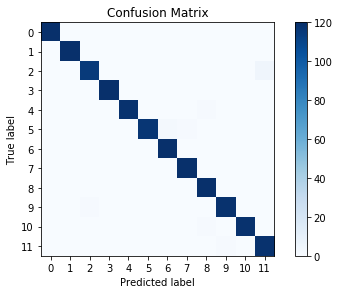

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1><center>EXPERIMENTS ON MY OWN NETWORKS</center></h1>

<h1>Defining Transforms to apply on the data according to the requirement of my Networks</h1>

In [0]:
# no need to add horizontal flip.
train_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),])

training_images = datasets.ImageFolder(path + '/train', transform=train_transform)
testing_images = datasets.ImageFolder(path + '/test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(training_images, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_images, batch_size=8, shuffle=True)

classes = training_images.classes

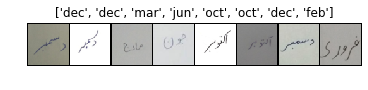

In [0]:
# code adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
'''
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
'''

<h1>My first Network (no BN, no dropout, no mean image subtraction)</h1>

In [0]:
class My_Network(nn.Module):
    def __init__(self):
        super(My_Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3),
            nn.ReLU(),            
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(24, 20, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
        )
        self.fc = nn.Sequential(
            nn.Linear(20*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 12),
        )
        return
    
    def forward(self, x):
        x = self.features(x)
        #print((x.shape))
        x = x.view(-1, 20*6*6)
        x = self.fc(x)
        return x

<h1>Experiment 1(no BN, no dropout, no mean image subtraction)</h1>

In [0]:
my_model = My_Network()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model.to(gpu)
my_model.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

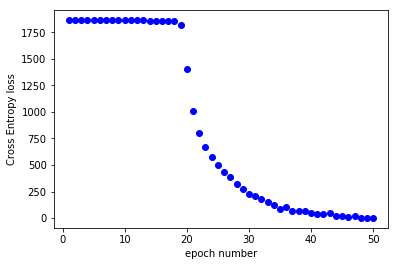

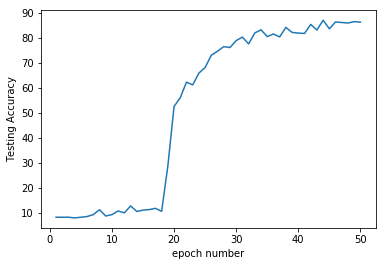

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

86.25


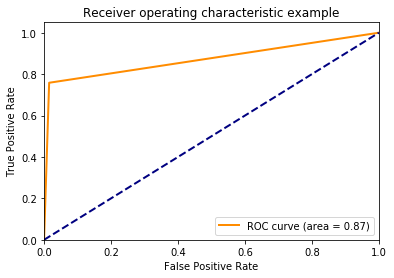

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[110   0   0   0   3   1   3   0   2   0   1   0]
 [  0 111   0   0   0   0   0   0   1   0   6   2]
 [  0   0  91   0   0   0   0   3   0   6   2  18]
 [  0   1   1 110   3   1   2   0   0   2   0   0]
 [  0   0   0   3 111   0   4   0   0   0   1   1]
 [  0   0   0   2   0 107   4   4   1   1   0   1]
 [  1   1   0   3   8   1  96   7   2   0   0   1]
 [  1   1   2   0   1   1   9  89   2   1  13   0]
 [  1   0   0   0   1   2   2   2 108   2   0   2]
 [  2   1  11   0   0   0   0   0   1  98   2   5]
 [  1   4   1   1   0   0   0   0   1  10 100   2]
 [  0   0   5   0   0   0   0   0   3   0   1 111]]


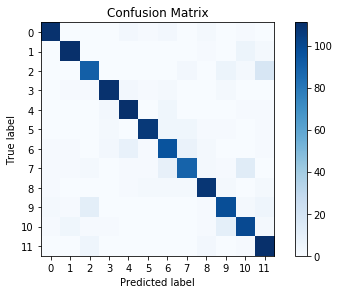

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Computing Mean image to subtract from all images</h1>

In [0]:
import glob
import numpy as np
import random
import scipy.misc as img

def load_dataset(path):
    print('Loading Dataset...')
    train_x =[]
    train_y =[]
    test_x  =[]
    test_y  =[]
    for i in classes:
        #print((path+'\\train\\'+str(i) +'\\*.png'))
        for filename in glob.glob(path+'/train/'+str(i) +'/*.png'):
            #print (filename)
            im = img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    
    for i in classes:
        for filename in glob.glob(path+'/test/'+str(i) +'/*.png'):
            im = img.imread(filename)
            test_x.append(im)
            test_y.append(i)
            
    print('Dataset Loaded...')
    return np.array(train_x),np.array(train_y),np.array(test_x),np.array(test_y)
        
   

In [0]:
train_set_x, train_set_y, test_set_x, test_set_y = load_dataset(path)

Loading Dataset...
/content/data/cropped_months\train\apr\*.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


/content/data/cropped_months\train\aug\*.png
/content/data/cropped_months\train\dec\*.png
/content/data/cropped_months\train\feb\*.png
/content/data/cropped_months\train\jan\*.png
/content/data/cropped_months\train\jul\*.png
/content/data/cropped_months\train\jun\*.png
/content/data/cropped_months\train\mar\*.png
/content/data/cropped_months\train\may\*.png
/content/data/cropped_months\train\nov\*.png
/content/data/cropped_months\train\oct\*.png
/content/data/cropped_months\train\sep\*.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Dataset Loaded...


(173, 263, 3)


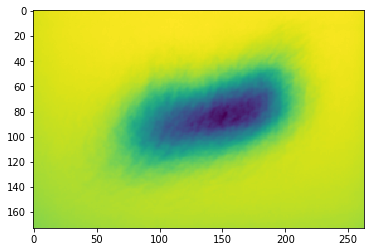

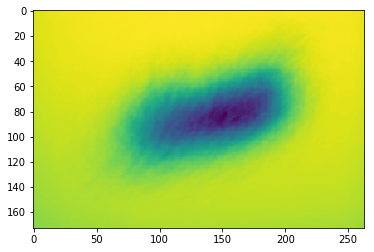

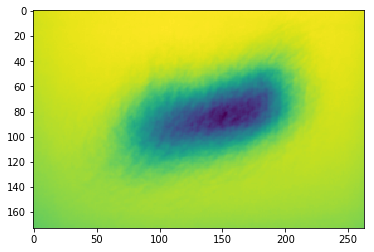

In [0]:
mean_image_from_train_set = train_set_x.mean(axis=0)
#print(mean_image_from_train_set)
print(mean_image_from_train_set.shape)
plt.imshow(mean_image_from_train_set[:,:,0])
plt.show()
plt.imshow(mean_image_from_train_set[:,:,1])
plt.show()
plt.imshow(mean_image_from_train_set[:,:,2])
plt.show()

In [0]:
mean_image_from_train_set1=torch.Tensor(mean_image_from_train_set)
transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
mean_image_from_train_set1 = transform(mean_image_from_train_set1)
mean_image_from_train_set1.shape


torch.Size([3, 64, 64])

<h1>Experiment 2(no BN, no dropout, mean image subtraction applied on data)</h1>

In [0]:
my_model1 = My_Network()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model1.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model1.to(gpu)
my_model1.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(35):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x = x - mean_image_from_train_set1
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model1(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x = x - mean_image_from_train_set1
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model1(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x = x - mean_image_from_train_set1
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model1(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

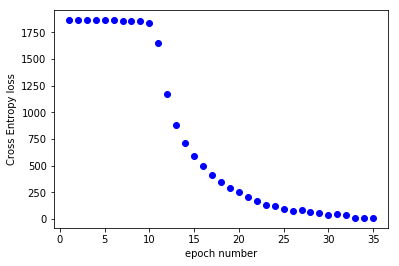

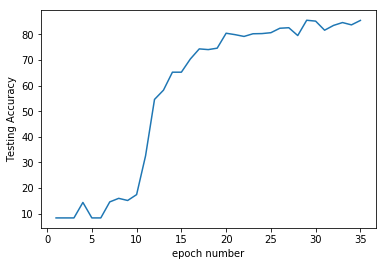

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model1(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

83.88888888888889


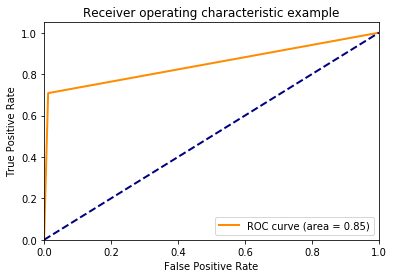

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[109   0   0   0   2   1   6   1   1   0   0   0]
 [  0 109   0   2   0   1   1   0   5   0   1   1]
 [  0   0  85   0   1   0   0   2   0  15   3  14]
 [  0   2   0 107   4   1   4   2   0   0   0   0]
 [  1   2   0   3 104   0   8   1   1   0   0   0]
 [  0   0   0   3   1 103  10   2   0   0   0   1]
 [  3   1   0   0   4   1 108   2   1   0   0   0]
 [  0   3   0   1   0   0  12 100   2   0   1   1]
 [  3   0   0   0   0   2   9   1 104   0   1   0]
 [  1   4   9   0   0   0   0   4   4  94   1   3]
 [  0  11   0   1   1   0   2   2   0  11  90   2]
 [  3   2   7   0   0   0   0   0   7   2   4  95]]


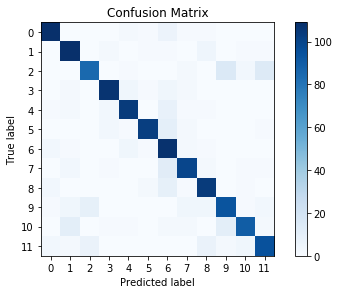

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>My Second Network (Added BN, no dropout, no mean image subtraction)</h1>

In [0]:
class My_Network_BN(nn.Module):
    def __init__(self):
        super(My_Network_BN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3),
            nn.BatchNorm2d(12),
            nn.ReLU(),            
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(24, 20, kernel_size=3),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
        )
        self.fc = nn.Sequential(
            nn.Linear(20*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 12),
        )
        return
    
    def forward(self, x):
        x = self.features(x)
        #print((x.shape))
        x = x.view(-1, 20*6*6)
        x = self.fc(x)
        return x

<h1>Experiment 3(Added BN, no dropout, no mean image subtraction)</h1>

In [0]:
my_model2 = My_Network_BN()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model2.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model2.to(gpu)
my_model2.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model2(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model2(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model2(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

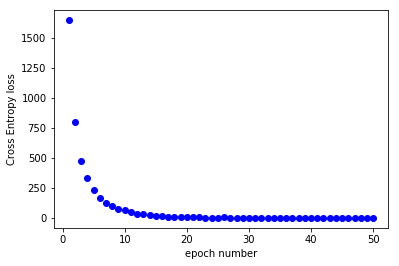

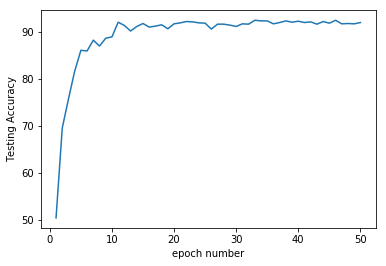

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model2(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

92.5


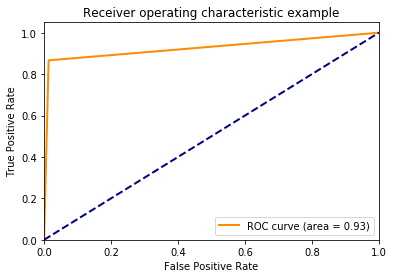

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[119   0   0   1   0   0   0   0   0   0   0   0]
 [  0 117   1   0   0   0   0   1   0   0   1   0]
 [  0   0 104   0   1   1   0   1   0   8   4   1]
 [  2   0   0 108   3   4   1   2   0   0   0   0]
 [  0   0   1   3 111   0   4   0   0   0   1   0]
 [  0   0   0   2   1 114   2   1   0   0   0   0]
 [  1   0   2   6   4   0 106   0   1   0   0   0]
 [  1   0   0   0   0   0   0 117   1   1   0   0]
 [  0   0   0   0   1   0   1   0 117   0   0   1]
 [  1   0  13   0   0   0   0   0   3  98   4   1]
 [  0   0   0   0   0   0   1   0   0   8 110   1]
 [  0   1   1   0   0   0   0   0   3   2   2 111]]


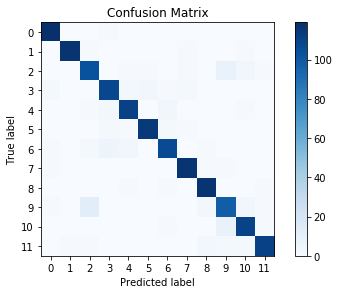

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>My Third Network (no BN, Added dropout, no mean image subtraction)</h1>

In [0]:
class My_Network_dropout(nn.Module):
    def __init__(self):
        super(My_Network_dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3),
            nn.ReLU(),            
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(12, 24, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(24, 20, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            
            
        )
        self.fc = nn.Sequential(
            nn.Linear(20*6*6, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 12),
        )
        return
    
    def forward(self, x):
        x = self.features(x)
        #print((x.shape))
        x = x.view(-1, 20*6*6)
        x = self.fc(x)
        return x

<h1>Experiment 4(no BN, Added dropout, no mean image subtraction)</h1>

In [0]:
my_model3 = My_Network_dropout()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model3.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model3.to(gpu)
my_model3.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model3(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model3(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model3(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model3.parameters(), lr=0.001, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model3.to(gpu)
my_model3.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(15):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model3(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model3(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model3(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

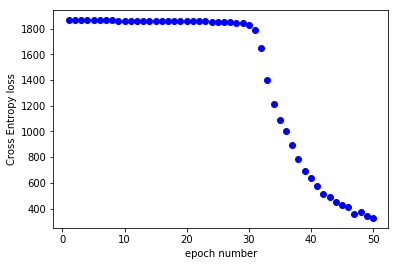

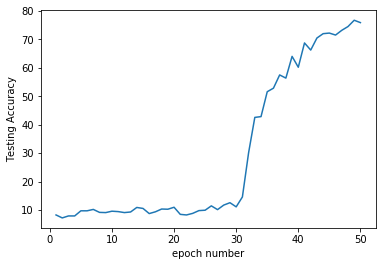

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model3(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

78.33333333333333


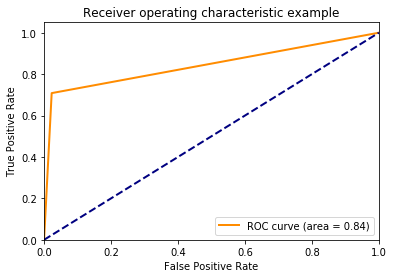

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[ 90   0   0   0   8   6   9   3   2   1   1   0]
 [  0 107   1   1   3   1   1   1   2   1   1   1]
 [  0   1  94   0   1   0   0   2   1   6   2  13]
 [  2   3   1  90  17   1   2   3   0   1   0   0]
 [  0   0   1   4 107   0   4   1   1   0   1   1]
 [  0   1   0   2   4  99   4   8   2   0   0   0]
 [  3   3   0   7  28   1  65   7   4   1   1   0]
 [  0   3   1   2   6   0   7  92   4   1   2   2]
 [  0   0   0   0   1   1   4   1 108   1   0   4]
 [  0   1   8   1   1   0   0   1   5  96   3   4]
 [  0   1   1   1   5   1   0   0   2  22  83   4]
 [  0   5   5   0   0   1   0   0   8   4   0  97]]


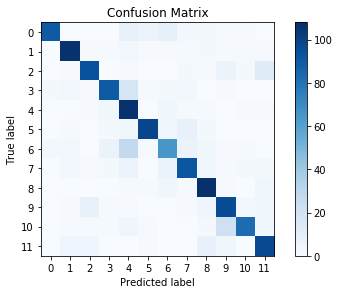

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 5(Trying Different Learning Rates)</h1>

<h1>Experiment 5a. Learning Rates= 0.003</h1>

In [0]:
my_model4 = My_Network_BN()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model4.parameters(), lr=0.003, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model4.to(gpu)
my_model4.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model4(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model4(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model4(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

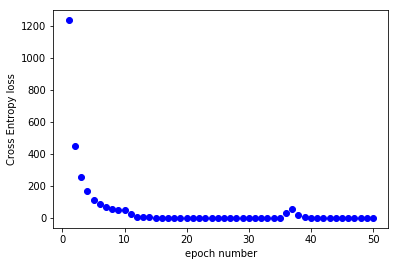

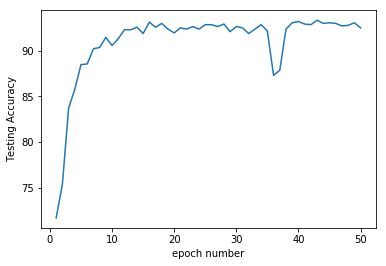

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model4(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

93.125


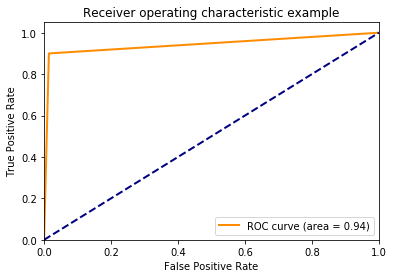

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[118   0   0   1   0   0   1   0   0   0   0   0]
 [  0 116   0   0   0   0   0   0   0   2   2   0]
 [  0   0 108   0   0   0   0   3   0   3   0   6]
 [  2   0   1 111   4   0   0   1   0   0   1   0]
 [  0   1   0   2 111   0   4   0   1   0   0   1]
 [  0   0   0   0   1 117   2   0   0   0   0   0]
 [  1   0   0   4   4   2 107   1   1   0   0   0]
 [  0   0   0   0   0   1   0 116   1   1   1   0]
 [  0   0   0   0   0   0   1   0 118   0   0   1]
 [  0   0  15   0   0   0   0   1   1 100   2   1]
 [  0   1   1   0   0   0   0   0   1  11 104   2]
 [  0   0   2   0   0   0   0   0   3   0   0 115]]


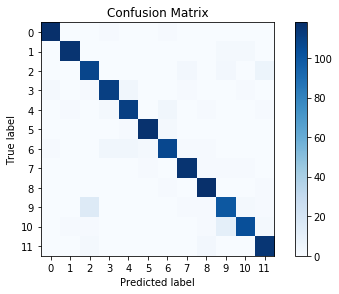

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 5b. Learning Rates= 0.009</h1>

In [0]:
my_model5 = My_Network_BN()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.SGD(my_model5.parameters(), lr=0.009, momentum=0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model5.to(gpu)
my_model5.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model5(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model5(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model5(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

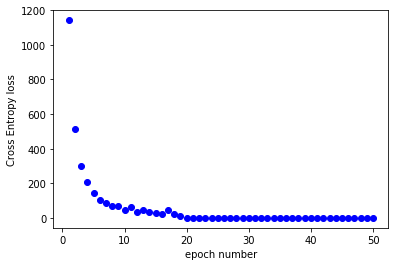

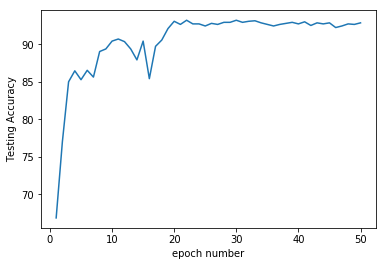

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model5(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

92.63888888888889


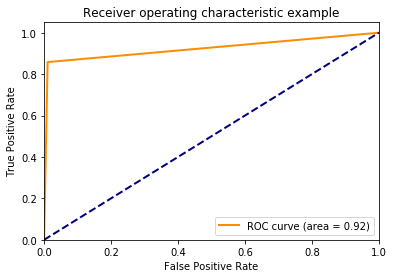

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[118   0   0   0   0   1   0   1   0   0   0   0]
 [  0 118   0   0   0   0   0   1   1   0   0   0]
 [  0   0 103   0   0   0   1   3   0   7   1   5]
 [  0   0   1 110   3   1   1   0   0   2   2   0]
 [  2   0   1   4 107   0   6   0   0   0   0   0]
 [  0   0   0   1   2 113   4   0   0   0   0   0]
 [  1   1   0   2   3   0 111   0   2   0   0   0]
 [  0   1   1   0   0   0   0 118   0   0   0   0]
 [  0   0   0   0   0   2   1   0 117   0   0   0]
 [  0   0   9   0   0   0   1   2   0 102   4   2]
 [  0   2   1   0   0   0   0   1   0  11 104   1]
 [  0   0   1   0   0   0   0   0   3   1   2 113]]


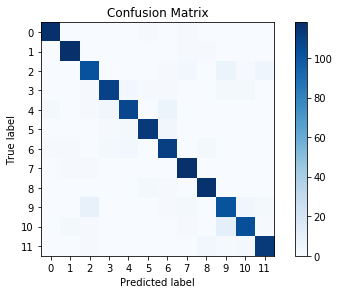

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 6(Trying Different Optimization functions)</h1>

<h1>Experiment 6a. Optimizer = Adam</h1>

In [0]:
my_model6 = My_Network_BN()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.Adam(my_model6.parameters(), lr=0.001)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model6.to(gpu)
my_model6.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model6(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model6(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model6(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

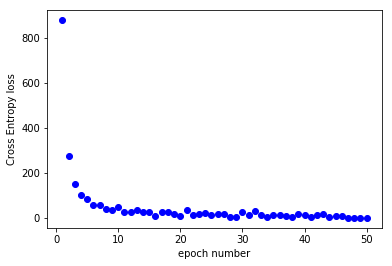

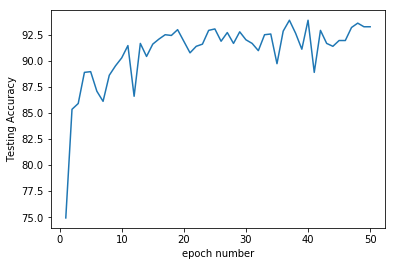

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model6(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

93.47222222222223


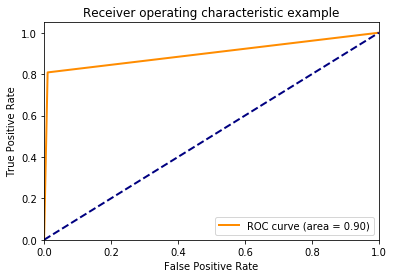

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[116   0   1   0   0   1   2   0   0   0   0   0]
 [  0 117   0   0   0   0   0   2   0   0   1   0]
 [  0   0  97   0   1   2   1   0   0   7   4   8]
 [  1   0   2 113   3   1   0   0   0   0   0   0]
 [  0   0   0   2 108   1   7   0   1   0   1   0]
 [  0   0   0   0   1 118   1   0   0   0   0   0]
 [  0   0   0   1   3   0 113   1   2   0   0   0]
 [  1   0   0   0   0   1   0 118   0   0   0   0]
 [  0   0   0   0   1   1   2   0 113   0   1   2]
 [  0   0  10   0   1   0   1   0   0 105   3   0]
 [  0   0   0   0   0   1   0   0   1   7 111   0]
 [  0   0   1   0   0   0   0   0   0   1   1 117]]


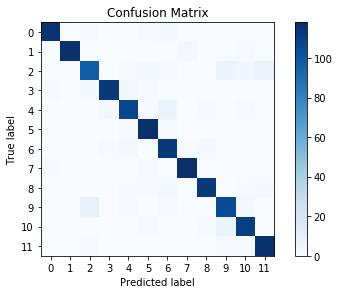

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 6a. Optimizer = RMSprop</h1>

In [0]:
my_model7 = My_Network_BN()

In [0]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.RMSprop(my_model7.parameters(), lr=0.001, momentum = 0.9)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model7.to(gpu)
my_model7.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model7(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model7(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model7(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

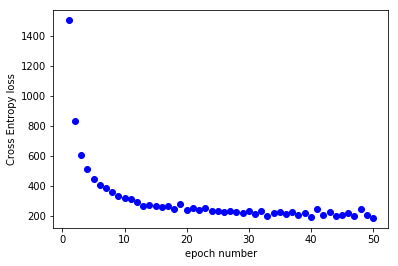

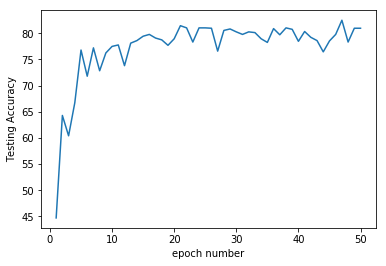

In [0]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [0]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model7(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

81.52777777777777


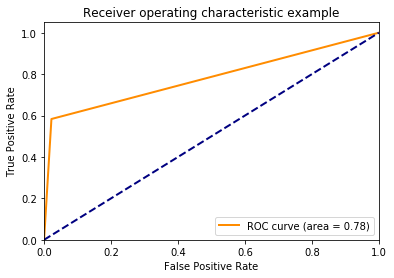

In [0]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[111   0   0   2   0   4   3   0   0   0   0   0]
 [  2 109   1   1   0   0   1   1   1   0   2   2]
 [  0   1  70   0   3   1   1   1   0  17   3  23]
 [  6   5   1  92   9   1   2   0   0   1   3   0]
 [  1   2   0   3  91   5  17   0   1   0   0   0]
 [  5   0   0   2   2 107   3   0   0   0   0   1]
 [  6   1   0   2   9   2  94   0   4   0   0   2]
 [  0   0   0   0   1   3   2 112   1   1   0   0]
 [  1   4   0   0   1   0   0   0 107   1   0   6]
 [  1   0  13   1   0   0   0   5   3  87   5   5]
 [  2   2   4   0   1   0   1   2   1   8  96   3]
 [  0   1  10   0   1   0   0   0   5   4   1  98]]


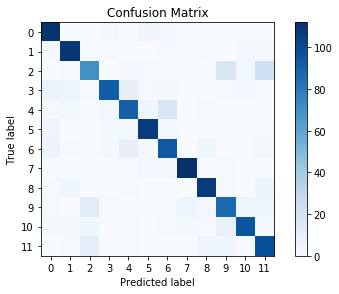

In [0]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 7(Trying Different Batch Sizes)</h1>

<h1>Experiment 7a. Batch Size = 64</h1>

In [0]:
# no need to add horizontal flip.
train_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),])

training_images = datasets.ImageFolder(path + '/train', transform=train_transform)
testing_images = datasets.ImageFolder(path + '/test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(training_images, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_images, batch_size=64, shuffle=True)

classes = training_images.classes

In [0]:
my_model8 = My_Network_BN()

In [15]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.Adam(my_model8.parameters(), lr=0.001)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model8.to(gpu)
my_model8.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model8(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model8(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model8(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

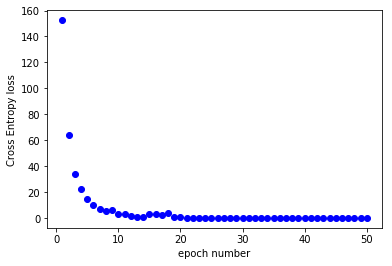

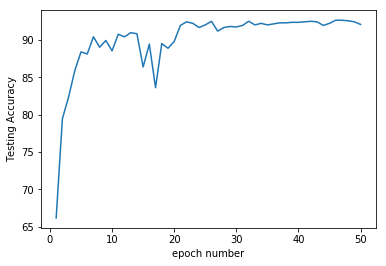

In [16]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [17]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model8(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

92.5


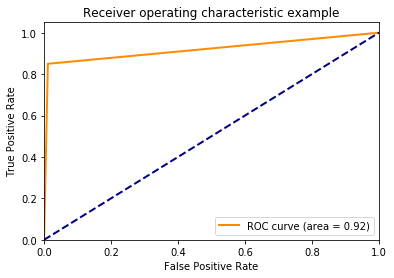

In [18]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[119   0   0   0   0   1   0   0   0   0   0   0]
 [  0 116   0   0   0   0   0   1   0   1   2   0]
 [  0   0 102   0   0   1   1   2   0   3   1  10]
 [  0   0   1 109   5   3   1   0   0   1   0   0]
 [  0   0   3   3 108   2   2   0   0   1   0   1]
 [  0   0   0   1   0 114   4   1   0   0   0   0]
 [  0   0   1   4   4   3 108   0   0   0   0   0]
 [  1   0   0   0   0   1   0 116   0   2   0   0]
 [  0   0   0   0   0   1   1   0 115   1   0   2]
 [  1   0   6   0   0   0   1   0   1 104   3   4]
 [  0   0   1   0   0   0   0   3   0   8 107   1]
 [  0   1   3   0   1   0   0   0   0   1   0 114]]


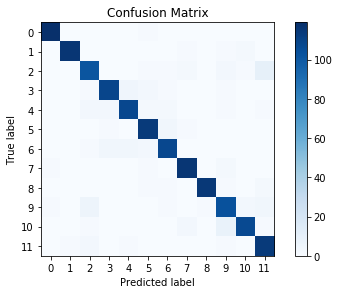

In [19]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1>Experiment 7a. Batch Size = 256</h1>

In [0]:
# no need to add horizontal flip.
train_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),])

training_images = datasets.ImageFolder(path + '/train', transform=train_transform)
testing_images = datasets.ImageFolder(path + '/test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(training_images, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_images, batch_size=256, shuffle=True)

classes = training_images.classes

In [0]:
my_model9 = My_Network_BN()

In [22]:
Cross_Entropy_Loss = nn.CrossEntropyLoss()
SGD_momentum = optim.Adam(my_model9.parameters(), lr=0.001)
from tqdm import tqdm_notebook as tqdm
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model9.to(gpu)
my_model9.train()
Losses = []
Accuracies =[]
Training_Accuracies =[]

Epochs =[]


for epoch in range(50):
    Epochs.append(epoch+1)
    loss_in_epoch = 0.0
    pbar = tqdm(enumerate(train_loader))
    for i, samples in pbar:
        x,y = samples
        x,y = x.to(gpu), y.to(gpu)
        SGD_momentum.zero_grad()
        predictions = my_model9(x)               
        loss = Cross_Entropy_Loss(predictions,y)   
        loss.backward()                     
        SGD_momentum.step()                    
        loss_in_epoch += loss.item()
    #Loss
    Losses.append(loss_in_epoch)
    #Accuracy
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for data in test_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model9(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    accuracy = (correct_predictions/total_samples) * 100
    Accuracies.append(accuracy)
    '''
    with torch.no_grad():
        for data in train_loader:
            x,y = data
            x,y = x.to(gpu), y.to(gpu)
            predictions = my_model9(x)
            _, pred_y = torch.max(predictions.data, 1)
            correct_predictions += (pred_y == y).sum().item()
            total_samples += y.size(0)
    t_accuracy = (correct_predictions/total_samples) * 100
    Training_Accuracies.append(t_accuracy)
    '''

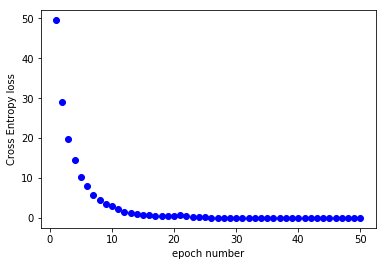

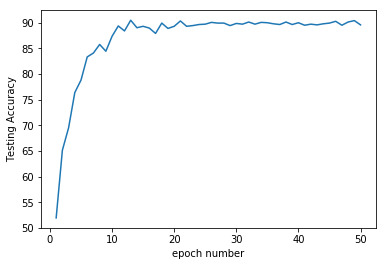

In [23]:
plt.plot(Epochs,Losses,'bo')
plt.xlabel('epoch number')
plt.ylabel('Cross Entropy loss')
plt.show()
#plt.plot(Epochs,Training_Accuracies)
#plt.xlabel('epoch number')
#plt.ylabel('Training Accuracy')
#plt.show()
plt.plot(Epochs,Accuracies)
plt.xlabel('epoch number')
plt.ylabel('Testing Accuracy')
plt.show()

In [24]:
actual_Y=[]
predicted_Y=[]
total_samples = 0
correct_predictions = 0
with torch.no_grad():
    for data in test_loader:
        x,y = data
        for l in y:
            actual_Y.append(int(l))
        x,y = x.to(gpu), y.to(gpu)
        predictions = my_model9(x)
        _, pred_y = torch.max(predictions.data, 1)
        for l in pred_y:
            predicted_Y.append(int(l))
        correct_predictions += (pred_y == y).sum().item()
        total_samples += y.size(0)
accuracy = (correct_predictions/total_samples) * 100
print(accuracy)

90.0


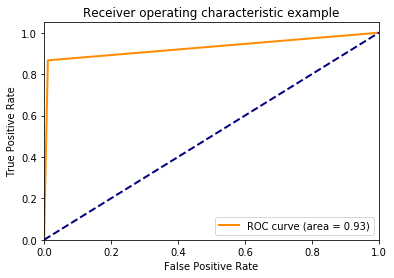

In [25]:
actual_Y1 =  label_binarize(actual_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])
predicted_Y1 =  label_binarize(predicted_Y, classes=[0,1,2,3,4,5,6,7,8,9,10,11])

# code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actual_Y1[:, i], predicted_Y1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_Y1.ravel(), predicted_Y1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[118   0   0   0   0   0   1   1   0   0   0   0]
 [  0 117   1   0   0   0   0   1   1   0   0   0]
 [  0   0 104   0   0   0   0   1   0   4   6   5]
 [  2   0   0 103   6   4   0   2   0   2   1   0]
 [  1   0   0   5  98   5   7   1   0   0   1   2]
 [  3   0   0   4   1 102   7   2   0   1   0   0]
 [  3   1   1   4   3   0 103   1   3   0   1   0]
 [  1   0   1   0   0   2   2 112   0   2   0   0]
 [  0   0   0   0   0   0   3   1 113   1   0   2]
 [  0   0   5   0   0   1   0   0   0 108   4   2]
 [  0   0   2   0   0   0   0   1   1   8 108   0]
 [  0   0   5   0   0   0   0   0   3   0   2 110]]


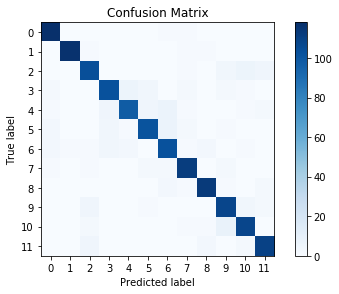

In [26]:
cnf_mat = confusion_matrix(actual_Y, predicted_Y)
print(cnf_mat)
class_labels = ['0', '1','2','3','4','5','6','7','8','9','10','11']
plt.imshow(cnf_mat,interpolation = 'nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)#, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<h1><center>THE END</center></h1>
<h2><center>finally!</center></h2>